Worked with custom functions

# Import the libaries

In [48]:
import tensorflow as tf
from tensorflow import keras
import numpy
import os
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
#from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras import constraints 
#from tensorflow.keras import utils

In [2]:
seed = 21

# Load and prepare the data

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Custom

In [4]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [5]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [6]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(MyDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super(MyDense, self).build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [7]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

# Compile model

In [8]:
model.compile(loss=my_mse, optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=[my_mae])

# Fit and evaluate

In [9]:
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing metric my_mae()
Tracing loss my_mse()
Train on 11610 samples, validate on 3870 samples
Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
10656/11610 [==========================>...] - ETA: 0s - loss: 3.4580 - my_mae: 1.5170Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
11610/11610 [==============================] - 1s 54us/sample - loss: 3.3375 - my_mae: 1.4805 - val_loss: 2.1144 - val_my_mae: 0.9966
Epoch 2/2
11610/11610 [==============================] - 0s 38us/sample - loss: 1.2443 - my_mae: 0.7926 - val_loss: 1.4720 - val_my_mae: 0.6479


In [10]:
print(model.summary())

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense (MyDense)           multiple                  270       
_________________________________________________________________
my_dense_1 (MyDense)         multiple                  930       
_________________________________________________________________
my_dense_2 (MyDense)         multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________
None


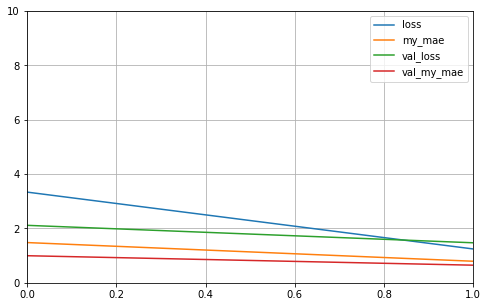

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 10)
    plt.show()

plot_learning_curves(history)

In [12]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 21us/sample - loss: 0.8641 - my_mae: 0.6448


[0.8640949485837951, 0.6448175]

In [13]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 64.48%


### Tensorflow Serving

In [52]:
MODEL_NAME = "my_fashion_mnist"

In [53]:
for root, dirs, files in os.walk(MODEL_NAME):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

my_fashion_mnist/
    1598452857/
        saved_model.pb
        assets/
        variables/
            variables.data-00000-of-00001
            variables.index


In [57]:
X_new = X_test[:3]

In [62]:
import json

input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist(),
})
print(input_data_json[:200] + "..." + input_data_json[-200:])

{"signature_name": "serving_default", "instances": [[-1.157801044672084, -0.28673138272452353, -0.49550876553420803, -0.16618096584447373, -0.029460121855354803, 0.38899735425767396, 0.193748207791791...085982, 0.062152314019760624], [-0.21561010032058425, 1.849189497070548, -0.5798278760656232, 0.18528489288618866, -0.10429402718436985, -0.6769490515190195, 1.0089019285606207, -1.4271528977404662]]}


In [63]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_fashion_mnist:predict'
            
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status()
response = response.json()

HTTPError: 400 Client Error: Bad Request for url: http://localhost:8501/v1/models/my_fashion_mnist:predict

In [64]:
response.keys()

AttributeError: 'Response' object has no attribute 'keys'